<a href="https://colab.research.google.com/github/asokraju/Power-Converters/blob/verified/gym_enviroments/boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Buck converter

In the we present the model of a buck dc-dc converter in OpenAI gym environment.

In [ ]:
import numpy as np
import gym
from gym import spaces

import matplotlib.pyplot as plt

#Physical Model
The dynamics of the Buck converter are:
\begin{align}
-L\dot{I} &= RI+V-uV_s\\
C\dot{V} &= I-GV
\end{align}


> ![alt text](https://i.imgur.com/AdJlqEN.png)







The parameters are:


*   L - Inductance
*   C - Capacitance
*   R - Series Resistance
*   G - Load Impedance
*   $V_s$ - Source Voltage

The state variables:
*  $I\geq 0$ - current through the inductor
*  $V\geq 0$ - voltage across the Capacitor

Input:
* $u\in (0,1)$ - duty-ratio

## Reward function

The Objective is to find an optimal policy for $u$ such that the Voltage $V$ across the capacitor is $V_d$. Consequently, we define the reward function as:

\begin{align}
r(I,V, u) & = - (V-V_d)^2 
\end{align}




In [ ]:
#@title ##Parameters

#@markdown ---

#@markdown ###System Parameters (Units in 1e-3).
Capacitance = 1 #@param {type:"slider", min:1, max:100, step:0.1}
Inductance = 1 #@param {type:"slider", min:1, max:100, step:0.1}

Resistance = 0 #@param {type:"slider", min:0, max:100, step:0.1}
load = 38.8 #@param {type:"slider", min:1, max:100, step:0.1}

#@markdown Voltage Source.
Vs = 380 #@param {type:"slider", min:100, max:500, step:10}

#@markdown Desired Voltage.
Vd = 280 #@param {type:"slider", min: 100, max:500, step:10}


C = Capacitance*1e-3
L = Inductance*1e-3
R = Resistance*1e-3
G = load*1e-3


# Gym Model

# New Section

In [ ]:
class Buck_Converter_n(gym.Env):
    """
    Buck converter model following gym interface
    We are assuming that the switching frequency is very High
    Action space is continious
    """
    metadata = {'render.modes': ['console']}

    def __init__(self, Vs = 400, L = 0.001, C = 0.001, R = 0.001, G = 0.04, Vdes = 380, dt = 1e-5):
        super(Buck_Converter_n, self).__init__()

        #parameters
        self.Vs = Vs
        self.L = L
        self.C = C
        self.R = R
        self.G = G

        #step size; since L and C are very low, the ode becomes stiff
        #For the default parameters the step size should in the order of 1e-5
        self.T = dt

        #the steady-state equilibrium of the system is
        self.Vdes = Vdes
        self.Ides = self.G * self.Vdes
        self.udes = (1/self.Vs) * (1 + self.G * self.R) * self.Vdes
        if self.Vs <= self.Vdes:
            raise ValueError("for buck converter desired voltage should be less the source Voltage")
        
        #The control action is duty-ratio which lies between 0 and 1 (We are assuming that the switching frequency is very High)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-np.inf, -np.inf]), high=np.array([+np.inf, +np.inf]), shape=None, dtype=np.float32)
        
        self._get_state()
    
    def _get_state(self):
        #initializing the state vector near to the desired values
        I = np.random.uniform(low = self.Ides*0.9, high = self.Ides*1.1)
        V = np.random.uniform(low = self.Vdes*0.9, high = self.Vdes*1.1)
        self.state = np.array([I, V])

    def _set_state(self, I, V):
        #using this function we can change the state variable
        self.state = np.array([I, V])

    def desired(self):
        #Provides the steady-state variables
        return np.array([self.Ides, self.Vdes, self.udes])

    def reset(self):
        """
        Important: re-initializing the state vector near to the desired values
        :return: (np.array) 
        """
        #self.state = np.array(np.random.normal([self.Ides , self.Vdes], 5)).astype(np.float32)
        self._get_state()
        return self.state
    
    def step(self, action):

        u = np.clip(action, 0, 1)

        i = self.state[0]
        v = self.state[1]

        didt = (-1.0/self.L)*(self.R*i + v - self.Vs*u)
        dvdt = (1.0/self.C)*(i - self.G*v)

        new_i = i + self.T * didt
        new_v = v + self.T * dvdt

        self.state = np.array([new_i, new_v]).astype(np.float32)

        # normalize the rewards
        reward = -((new_v-self.Vdes))**2
        done = False
        return self.state, reward, done, {}

    def render(self, mode='console'):
        # Prints the error between the desired values and their corresponding states
        ei = self.state[0] - self.Ides
        ev = self.state[1] - self.Vdes
        if mode != 'console':
            raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
        print("I-Ides = {:.2f}, V-Vdes = {:.2f}".format(ei, ev))

    def close(self):
        pass

# Testing

In [ ]:
def plot_signals(data, Ides, Vdes, dt = 1e-5):
    number_of_colors = data.shape[1]
    color = ['r', 'b']
    des = [Ides, Vdes]
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1], figsize = (8,4))
    time = np.array(range(data.shape[0]), dtype=np.float32)*dt
    for i in range(data.shape[1]):
        ax[i].plot(time, data[:, i],  c = color[i])
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(0, des[i]+50)
    ax[0].set_title('Current', fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_title('Voltage', fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)
    plt.show()

## Constant input policy

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


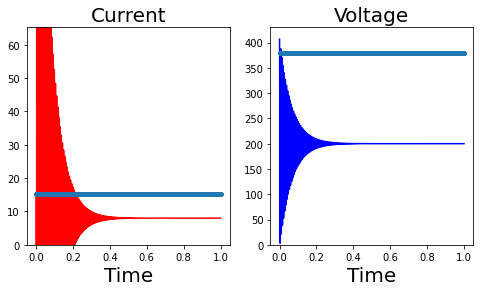

In [ ]:
env = Buck_Converter_n()

env.reset()

obs = []
for i in range(10**5):
    s, r, _, _ = env.step(0.5)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((10**5 ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5)

## Stabilizing  input policy

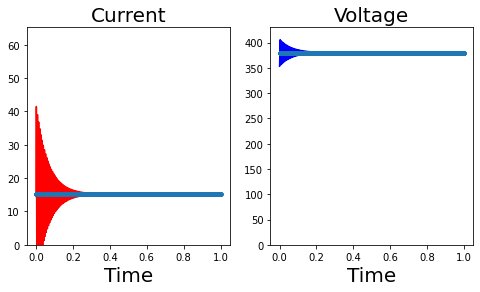

In [ ]:
env.reset()

obs = []
for i in range(10**5):
    s, r, _, _ = env.step(env.udes)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((10**5 ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5)